<a href="https://colab.research.google.com/github/EvieLynn26/nBSS_solver_by_CAMNS/blob/main/SelfTask2_Emelianova.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## A Convex Analysis Framework for Blind Separation of Non-Negative Sources

Предложено решить BSS (blind source separation) задачу при помощи алгоритма CAMNS (convex  analysis  of  mixtures  of  non-negative sources). Описанная схема является детерминированной, т.е. не требующей предположения о независимости источников. 

Однако мы основываемся на специальном предположении -- локальном доминировании, что позволяет применять выпуклый анализ.
Вторым необходимым требованием является неотрицательность источника: $$s[n] = [s_1[n], ..., s_N[n]]^T, n = 1, ..., L 
\\ s_i \geq 0, i \in \{1, ..N\}.$$

Число 𝐿 требуется много больше наибольшего из размерностей входных и выходных векторов. 

Модель сигнала описывается уравнением:
$${\bf{x}}[n] = 𝐀{\bf{s}}[n], n = 1, ..., L \\ 
x_i = \sum^{N}_{j=1}a_{ij}s_{j}, i = 1, ..., M.$$

Заметим, что размерности входных и выходных векторов не обязательно равны.

Задача разделения сигналов состоит в нахождении 𝐿 векторов-источников без знания матрицы 𝐀. Для решения примем некоторые условия:
* Все компоненты вектора-источника принимают только неотрицательные значения
* Для каждого вектора-сигнала верно свойство, называемое *local dominant*, заключающееся в том, что в наборе присутствует как минимум N  векторов-источников, у которых все координаты, кроме одной, равны нулю. Индекс координаты, принявшей положительное значение, в выбранном наборе принимает все значения от 1 до N.
* Сумма каждой строки смешивающей матрицы равна 1.
* Размерность вектора-наблюдения не меньше размерности вектора-источника, а также ранг смешивющей матрицы равен размерности векторов-наблюдений.

Для третьего свойства можно отнормировать матрицу по строкам. 

In [29]:
import cvxpy as cvx
import numpy as np
import matplotlib.pyplot as plt

In [30]:
#======================================================================
# function flag= is_ext_pt(C,d,alpha,tol)
#  Verify if alpha is an extreme point of the polyhedral set
#     { a | Ca+ d => 0 }
#---Inputs----
# (C,d) is the set of polyhedron parameters
# alpha is the point to be tested
# tol specifies the numerical tolerance (say, 1e-3)
#---Output----
# 1 if alpha is an extreme point; and 0 otherwise.
#=======================================================================
def is_ext_pt(C, d, alpha, tol=1e-6):
    L, D = C.shape
    T = C[np.all(np.abs(np.expand_dims(C.dot(alpha) + d, axis=1)) < tol, axis=1), :]
    if T.shape[0] == 0:
        return False
    ran = np.linalg.matrix_rank(T, tol=tol)
    return (ran == D)

#======================================================================
# A practical implementation of the CAMNS-LP method
#======================================================================
# Output: 
# hS is the L-by-N extracted soruce matrix, where L is the data length.
#---------------------------------------------------
# Inputs:
# X is the L-by-M observation matrix, where M is the number of
# observations.
# N is the number of sources. 
#========================================================================
def CAMNS_LP(X, N):    
    TOL_LP = 1e-3 # tolerance for (small) numerical errors in LP
    TOL_EXT = 1e-6 # tolerance for extreme-point validation
    TOL_ZEROS= 1e-6 # tolerance for eliminating zero observation points

    M, L = X.shape
    X = X.T
    d = np.mean(X, axis=1)
    # For computational efficiency, we use SVD of R instead of EVD of R*R'
    C, _, _ = np.linalg.svd(X - np.expand_dims(d, axis=1), full_matrices=False)
    C = C[:, :N-1]
    el = 0
    Q1 = np.diag(np.ones(L))
    hS = np.zeros((0, L))
    while el < N:
        w = np.random.normal(loc=0, scale=1, size=L)
        r = Q1.dot(w)
        
        alpha_1 = cvx.Variable(C.shape[1]) 
        p_star = cvx.Problem(cvx.Minimize(r.T @ (C @ alpha_1 + d)), [C @ alpha_1 + d >= 0]).solve(solver='ECOS_BB')
        alpha_2 = cvx.Variable(C.shape[1])
        q_star = cvx.Problem(cvx.Maximize(r.T @ (C @ alpha_2 + d)), [C @ alpha_2 + d >= 0]).solve(solver='ECOS_BB')

        if el == 0:
          if is_ext_pt(C, d, alpha_1.value, TOL_EXT):
            hS = np.append(hS, [(C @ alpha_1.value + d).squeeze()], axis=0)
          if is_ext_pt(C, d, alpha_2.value, TOL_EXT):
            hS = np.append(hS, [(C @ alpha_2.value + d).squeeze()], axis=0)
        else:
          if p_star / (np.linalg.norm(r) * np.linalg.norm(C @ alpha_1.value + d)) >= TOL_LP:
            if is_ext_pt(C, d, alpha_1.value, TOL_EXT):
              hS = np.append(hS, [(C @ alpha_1.value + d).squeeze()], axis=0)
          if q_star / (np.linalg.norm(r) * np.linalg.norm(C @ alpha_1.value + d)) >= TOL_LP:
            if is_ext_pt(C, d, alpha_2.value, TOL_EXT):
              hS = np.append(hS, [(C @ alpha_2.value + d).squeeze()], axis=0)

        el = hS.shape[0]

        if el > 0:
          Q, _ = np.linalg.qr(hS.T)
          Q1 = np.diag(np.ones(L)) - Q @ Q.T

    return hS

## demo_CAMNS_LP

В описании работы сказано, что алгоритм хорошо работает на высококонтрастных изображениях, например, портретах людей, но изображение кота тоже подойдет.

In [31]:
def load_image(path):
    img = plt.imread(path)
    if len(img.shape) > 2:
        img = np.delete(img, range(1, img.shape[2]), axis=2)
    return img.reshape(128 * 128).astype(np.float64) / 255.0

In [32]:
# Preparing observation-vectors
imgs = [load_image(path) for path in ['img/happy.jpg', 'img/norm.jpg', 'img/angry.jpg']]

# Preparing mixtured-vectors (input for CAMNS_LP alfo)
N = len(imgs)
# amount of observations
L = N
A = np.random.rand(L, N)
Normalized_A = A / np.sum(A, axis=1)
X = Normalized_A.dot(imgs)

In [33]:
# Getting out sourse-vectors
hS = CAMNS_LP(X, N)

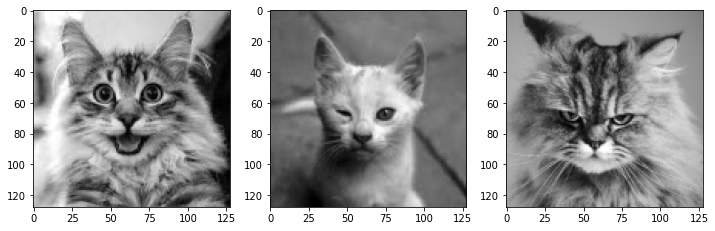

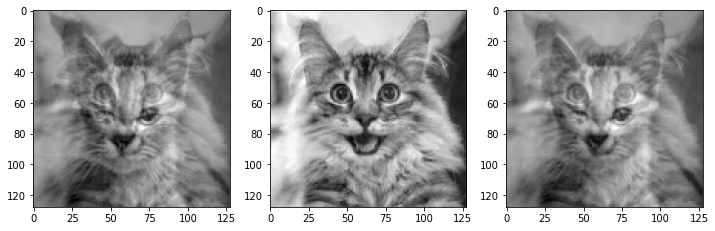

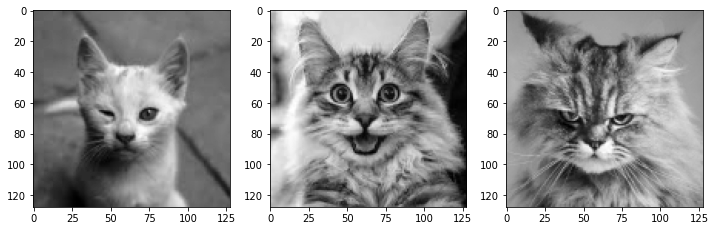

In [34]:
def output(imgs):    
    _, ax = plt.subplots(1, len(imgs), figsize=(4*len(imgs), 4))
    for i, img in enumerate(imgs):
        ax[i].imshow(img.reshape(128, 128), cmap=plt.cm.gray)

output(imgs)
output(X)
output(hS)

В качестве вывода хочется сказать, что метод можно применять не только для синтетической задачи разделения фотографий, смешанных при помощи одной (хоть и случайной) матицы А. Интересный пример использования в медицине: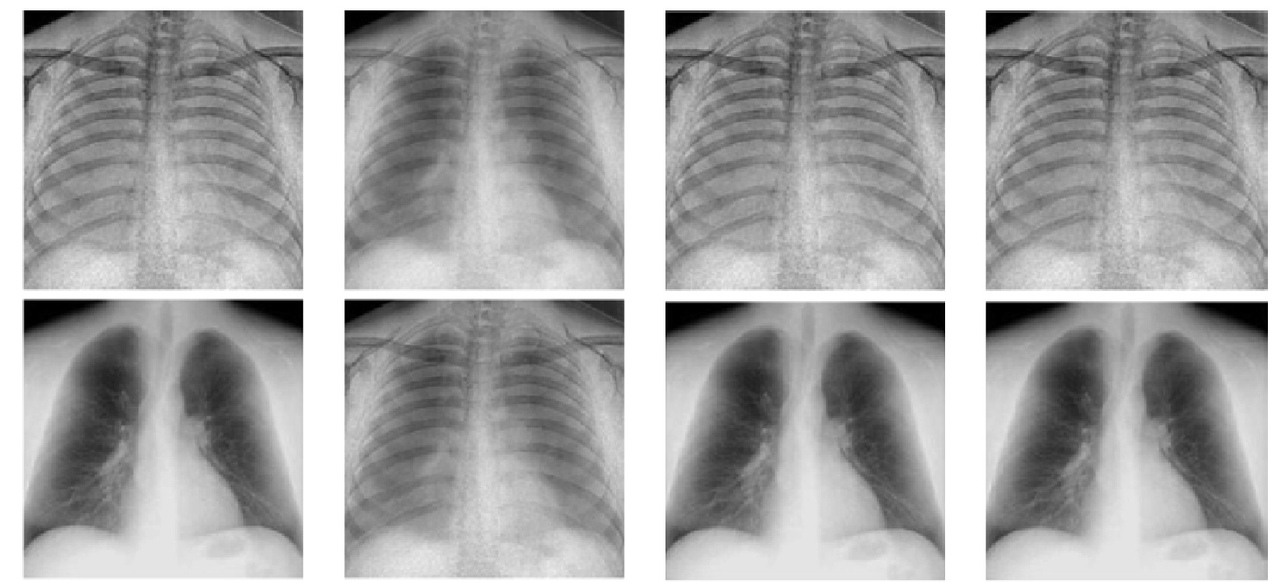